# All imports #

In [36]:
from __future__ import print_function

import sys, os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import tensorflow as tf
import tensorflow.keras
import pandas as pd
import numpy as np
import sklearn
import keras
import csv

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout

from keras_uncertainty.models import MCDropoutClassifier, MCDropoutRegressor
from keras_uncertainty.utils import numpy_regression_nll


In [37]:
def load_joint_space_csv_chunks(file_path):
    data_frame = pd.read_csv(file_path, skiprows=1, header=None)
    del data_frame[18]
    return data_frame

def load_task_space_csv_chunks(file_path):
    return pd.read_csv(file_path, skiprows=1, header=None)


In [38]:
##please select the appropriate folder, willl use os.path.join() for completed script
TRAIN_FOLDER = '/home/dfki.uni-bremen.de/bmanickavasakan/newdataset_rh5_leg/leg_5steps/'
TEST_FOLDER = '/home/dfki.uni-bremen.de/bmanickavasakan/newdataset_rh5_leg/leg_5steps/test_4steps'

X_TRAIN_FILE = os.path.join(TRAIN_FOLDER, 'leg_forwardkinematics_x.csv')
Q_TRAIN_FILE = os.path.join(TRAIN_FOLDER, 'leg_sysstate_q.csv')
x_train = load_task_space_csv_chunks(X_TRAIN_FILE)
q_train = load_joint_space_csv_chunks(Q_TRAIN_FILE)

X_TEST_FILE = os.path.join(TEST_FOLDER, 'leg_forwardkinematics_x.csv')
Q_TEST_FILE = os.path.join(TEST_FOLDER, 'leg_sysstate_q.csv')
x_test = load_task_space_csv_chunks(X_TEST_FILE)
q_test = load_joint_space_csv_chunks(Q_TEST_FILE)

# Building the model with MC Droput #

In [39]:
'''

Standard deviation based data splitting

We consider the Q features and use the feature with the 

highest SD for dividing the dataset
'''

stats_q_train = pd.DataFrame()
stats_q_train["Mean"] = q_train.mean()
stats_q_train["Var"] = q_train.var()
stats_q_train["STD"] = q_train.std()
stats_q_train["OneSigmaMax"] = stats_q_train["Mean"] + stats_q_train["STD"]
stats_q_train["OneSigmaMin"] = stats_q_train["Mean"] - stats_q_train["STD"]
stats_q_train.T

max_std = stats_q_train["STD"].max()
colomn_max_std = stats_q_train["STD"].idxmax()

maximum = stats_q_train.loc[colomn_max_std, "Mean"] + (1.5 * max_std)
minimum = stats_q_train.loc[colomn_max_std, "Mean"] - (1.5 * max_std)
print(maximum, minimum)

InDistribution_Q_Train = q_train[q_train[colomn_max_std].le(maximum) & q_train[colomn_max_std].ge(minimum)]
OutDistribution_Q_Train = q_train[q_train[colomn_max_std].ge(maximum) | q_train[colomn_max_std].le(minimum)]
InDistribution_X_Train = x_train[q_train[colomn_max_std].le(maximum) & q_train[colomn_max_std].ge(minimum)]
OutDistribution_X_Train = x_train[q_train[colomn_max_std].ge(maximum) | q_train[colomn_max_std].le(minimum)]

InDistribution_Q_Test = q_test[q_test[colomn_max_std].le(maximum) & q_test[colomn_max_std].ge(minimum)]
OutDistribution_Q_Test = q_test[q_test[colomn_max_std].ge(maximum) | q_test[colomn_max_std].le(minimum)]
InDistribution_X_Test = x_test[q_test[colomn_max_std].le(maximum) & q_test[colomn_max_std].ge(minimum)]
OutDistribution_X_Test = x_test[q_test[colomn_max_std].ge(maximum) | q_test[colomn_max_std].le(minimum)]

x_train_1 = InDistribution_X_Train
q_train_1 = InDistribution_Q_Train
x_test_1 = InDistribution_X_Test
q_test_1 = InDistribution_Q_Test

OOD_x_train = OutDistribution_X_Train
OOD_q_train = OutDistribution_Q_Train
OOD_x_test = OutDistribution_X_Test
OOD_q_test = OutDistribution_Q_Test



print("//////////////////////")
print(x_train_1.shape, OOD_x_train.shape, x_test_1.shape, OOD_x_test.shape)


0.9119140506494964 -0.5558160506494813
//////////////////////
(13750, 9) (1875, 9) (3840, 9) (256, 9)


In [40]:
print(x_train.shape, x_test.shape)

(15625, 9) (4096, 9)


In [41]:

x_scaler = MinMaxScaler()
q_scaler = MinMaxScaler()

#complete test set
x_train = x_scaler.fit_transform(x_train)
q_train = q_scaler.fit_transform(q_train)
x_test = x_scaler.transform(x_test)
q_test = q_scaler.transform(q_test)

#In order training set
x_train_1 = x_scaler.transform(x_train_1)
q_train_1 = q_scaler.transform(q_train_1)

IOD_x_train = x_train_1
IOD_q_train = q_train_1


#split testing data
IOD_x_test = x_scaler.transform(x_test_1)
IOD_q_test = q_scaler.transform(q_test_1)

OOD_x_test = x_scaler.transform(OOD_x_test)
OOD_q_test = q_scaler.transform(OOD_q_test)

In [42]:
dropoutRate = 0.5

In [43]:
def model_builder(input_shape, output_shape):
    def build_model(depth, width, reduction_factor):
        model = Sequential()

        for i in range(depth):
            num_neurons = max(int(width * (reduction_factor ** i)), 4)
            if i == 0:
                model.add(Dense(num_neurons, activation='relu', input_shape=(input_shape,)))
            else:
                model.add(Dropout(dropoutRate))
                model.add(Dense(num_neurons, activation='relu'))                

            model.add(BatchNormalization())

        model.add(Dense(output_shape, activation='sigmoid'))

        model.compile(loss='mse', optimizer='adam', metrics=["mae"])

        return model
    return build_model


In [66]:
HYPERPARAMETERS = {'depth': 6, 'width': 64, 'reduction_factor':  0.9}
with tf.device('/cpu:0'):
    model = model_builder(9, 18)(**HYPERPARAMETERS)
    hist = model.fit(x_train_1, q_train_1, epochs = 100, batch_size = 128, verbose = 1, validation_data=(IOD_x_test, IOD_q_test))

#use_multiprocessing=True, workers=1000

Train on 13750 samples, validate on 3840 samples
Epoch 1/100
13750/13750 [==============================] - 2s 148us/sample - loss: 0.1202 - mean_absolute_error: 0.2860 - val_loss: 0.1032 - val_mean_absolute_error: 0.2701
Epoch 2/100
13750/13750 [==============================] - 1s 48us/sample - loss: 0.0937 - mean_absolute_error: 0.2530 - val_loss: 0.1049 - val_mean_absolute_error: 0.2710
Epoch 3/100
13750/13750 [==============================] - 1s 49us/sample - loss: 0.0860 - mean_absolute_error: 0.2403 - val_loss: 0.0925 - val_mean_absolute_error: 0.2574
Epoch 4/100
13750/13750 [==============================] - 1s 49us/sample - loss: 0.0821 - mean_absolute_error: 0.2333 - val_loss: 0.0782 - val_mean_absolute_error: 0.2345
Epoch 5/100
13750/13750 [==============================] - 1s 48us/sample - loss: 0.0786 - mean_absolute_error: 0.2274 - val_loss: 0.0701 - val_mean_absolute_error: 0.2190
Epoch 6/100
13750/13750 [==============================] - 1s 47us/sample - loss: 0.0753 -

13750/13750 [==============================] - 1s 50us/sample - loss: 0.0327 - mean_absolute_error: 0.1317 - val_loss: 0.0224 - val_mean_absolute_error: 0.1044
Epoch 96/100
13750/13750 [==============================] - 1s 48us/sample - loss: 0.0324 - mean_absolute_error: 0.1310 - val_loss: 0.0224 - val_mean_absolute_error: 0.1039
Epoch 97/100
13750/13750 [==============================] - 1s 50us/sample - loss: 0.0325 - mean_absolute_error: 0.1309 - val_loss: 0.0224 - val_mean_absolute_error: 0.1042
Epoch 98/100
13750/13750 [==============================] - 1s 49us/sample - loss: 0.0324 - mean_absolute_error: 0.1309 - val_loss: 0.0226 - val_mean_absolute_error: 0.1042
Epoch 99/100
13750/13750 [==============================] - 1s 50us/sample - loss: 0.0324 - mean_absolute_error: 0.1308 - val_loss: 0.0225 - val_mean_absolute_error: 0.1044
Epoch 100/100
13750/13750 [==============================] - 1s 50us/sample - loss: 0.0328 - mean_absolute_error: 0.1320 - val_loss: 0.0228 - val_me

In [67]:
q_pred = model.predict(x_test, verbose=0)
q_unnorm = q_scaler.inverse_transform(q_test)
q_pred_unnorm = q_scaler.inverse_transform(q_pred)

global_mae = mean_absolute_error(q_test, q_pred)
mae_1 = mean_absolute_error(q_unnorm, q_pred_unnorm)

print("Testing MAE: {:.5f}".format(global_mae))
print("Testing MAEX: {:.5f}".format(mae_1))

'''
# Compute MAE for each output independently.
for i in range(IOD_q_test.shape[1]):
    norm_mae_i = mean_absolute_error(IOD_q_test[:, i], q_pred[:, i])
    mae_i = mean_absolute_error(q_unnorm[:, i], q_pred_unnorm[:, i])
    print("Q feature {} has unnorm MAE: {:.4f} (Range {:.4f} to {:.4f}) normalized MAE: {:.4f}".format(i, mae_i, q_scaler.data_min_[i], q_scaler.data_max_[i], norm_mae_i))
'''

Testing MAE: 0.10886
Testing MAEX: 0.07804


'\n# Compute MAE for each output independently.\nfor i in range(IOD_q_test.shape[1]):\n    norm_mae_i = mean_absolute_error(IOD_q_test[:, i], q_pred[:, i])\n    mae_i = mean_absolute_error(q_unnorm[:, i], q_pred_unnorm[:, i])\n    print("Q feature {} has unnorm MAE: {:.4f} (Range {:.4f} to {:.4f}) normalized MAE: {:.4f}".format(i, mae_i, q_scaler.data_min_[i], q_scaler.data_max_[i], norm_mae_i))\n'

# MC Dropout Regressor, O/P : mean, Std #

In [68]:
def test_mcdropout_regressor(x_test_values, q_test_values, model, data_scaler):   
    mc_model = MCDropoutRegressor(model)
    inp = x_test_values  
    
    mean, std = mc_model.predict(inp, num_samples = 10)
    
    q_pred_unnormalised = data_scaler.inverse_transform(mean)
    
    #q_sd_unnromalised = data_scaler.inverse_transform(std)
    
    global_mae = mean_absolute_error(q_test_values, mean)

    print("Testing MAE: {:.5f}".format(global_mae))

    return q_pred_unnormalised, std
  


In [69]:

mean_1, std_1 = test_mcdropout_regressor(x_test, q_test, model, q_scaler)

q_test_unorm = q_scaler.inverse_transform(q_test)



Testing MAE: 0.30185


In [70]:
sd_test_1 = pd.DataFrame(std_1)

print(sd_test_1[0].min())

0.0042438083


In [71]:
mean_test_IOD, sd_test_IOD = test_mcdropout_regressor(IOD_x_test, IOD_q_test, model, q_scaler)
q_test_unorm = q_scaler.inverse_transform(IOD_q_test)
print("NLL: {:.5f}".format(numpy_regression_nll(q_test_unorm, mean_test_IOD, sd_test_IOD**2)))

Testing MAE: 0.29542
NLL: 34.28814


In [72]:
mean_test_OOD, sd_test_OOD = test_mcdropout_regressor(OOD_x_test, OOD_q_test, model, q_scaler)
q_test_unorm = q_scaler.inverse_transform(OOD_q_test)
print("NLL: {:.5f}".format(numpy_regression_nll(q_test_unorm, mean_test_OOD, sd_test_OOD**2)))

Testing MAE: 0.39470
NLL: 43.80406


In [115]:
column_no = 2

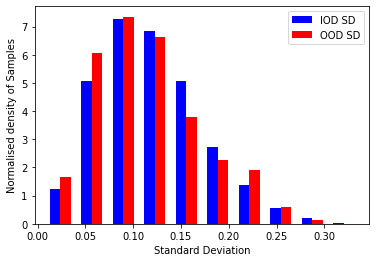

In [116]:
sd_test_IOD_df = pd.DataFrame(sd_test_IOD)
sd_test_OOD_df = pd.DataFrame(sd_test_OOD)
new_scores = np.concatenate([sd_test_IOD_df[column_no], sd_test_OOD_df[column_no]], axis=0)
minmaxscaler = MinMaxScaler()
new_scores_scaled = minmaxscaler.fit_transform(new_scores.reshape(-1, 1))
new_labels = np.concatenate([np.zeros_like(sd_test_IOD_df[column_no]), np.ones_like(sd_test_OOD_df[column_no])], axis=0)
histogram_df = pd.DataFrame(new_scores_scaled, new_labels)

#histogram_df.hist(column=0)

#sd_test_IOD_df.hist(column=0)
#sd_test_OOD_df.hist(column=0)
import matplotlib.pyplot as plt
fig, ax = plt.subplots()

a_heights, a_bins = np.histogram(sd_test_IOD_df[column_no].values.reshape(-1, 1), density=True)
b_heights, b_bins = np.histogram(sd_test_OOD_df[column_no].values.reshape(-1, 1), bins=a_bins, density=True)

width = (a_bins[1] - a_bins[0])/3

ax.bar(a_bins[:-1], a_heights, width = width, facecolor='blue',label="IOD SD")
ax.bar(b_bins[:-1]+width, b_heights, width = width, facecolor='red', label="OOD SD")
ax.legend()
ax.set_xlabel("Standard Deviation")
ax.set_ylabel("Normalised density of Samples")
fig.savefig("density_vs_sd_dropout_sd_split_col_2.pdf")


In [117]:
print(sd_test_IOD.shape[1])

18


0.4660929361979166


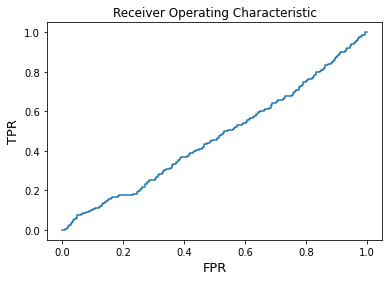

In [118]:
from sklearn.metrics import roc_curve, roc_auc_score
norm_scores = new_scores - min(new_scores) / (max(new_scores) - min(new_scores))

auc = roc_auc_score(new_labels, new_scores)
fpr, tpr, threshs = roc_curve(new_labels, norm_scores, drop_intermediate=True)
print(auc)

plt.xlabel('FPR', fontsize=13)
plt.ylabel('TPR', fontsize=13)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr)
plt.savefig("auc_dropout_sd_split_col_2.pdf")
plt.show()

